## Semi-supervised learning with geometry regularized neural networks

In this exercise we will reproduce the following architecture and employ it in a semi-supervised classification problem 

<img src="semi_supervised_arch.png" width=400 height=400 />

Each of the inner layers is mapped to a reference representation of the data given by a dimensionality reduction method. In this way the network is regularized. 

The loss function is then $\mathcal{L} = E[-log(\hat{y})] + \sum_{i = 1}^{Nh} ||\hat{g}^{i} - \mathcal{E}||_{F}^{2}$, the first term is the usual cross entropy loss for classification and $\hat{y}$ is the output of the last green layer in the figure. $g^{i}$ is the mapping from the inner layer $i$ to the red representations, and $\mathcal{E}$ is a reference embedding that we will see next.

Consider the following scenario:
We have some dataset for which only a portion of the data is labeled, we could train a classifier just with labeled observations. But, semi-supervised learning techniques include the unlabeled data to improve the performance. 

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import Dataset
import seaborn as sns
import pandas as pd
import sklearn

C:\Users\seanr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_pbmc(perc_labels = 0.1):
    X = np.loadtxt("ATAC_scaledata.txt")   
    true_labels = np.loadtxt("ATAC_type.txt")
    true_labels = true_labels.astype(int)
    
    
    # select some labels to remove for the experiments
    targets = true_labels.copy().astype(float)
    for p, i in enumerate(np.unique(true_labels)): 
        indx = np.where(true_labels == i)[0]
        # from the observarions with this label take a % off
        NlabelsRemove = int(np.floor(len(indx)*(1-perc_labels)))
        indxR = np.random.choice(indx, NlabelsRemove, replace = False)
        targets[indxR] = 'nan'
    test_ind = np.where(torch.isnan(torch.tensor(targets)))[0]
    return X, true_labels, targets, test_ind

X, true_labels, targets, test_ind = get_pbmc(perc_labels = 0.01)

In [3]:
# pip install umap-learn

In [4]:
import umap
Embedding = umap.UMAP(n_neighbors=20, n_components = 5, min_dist=0.01).fit_transform(X)

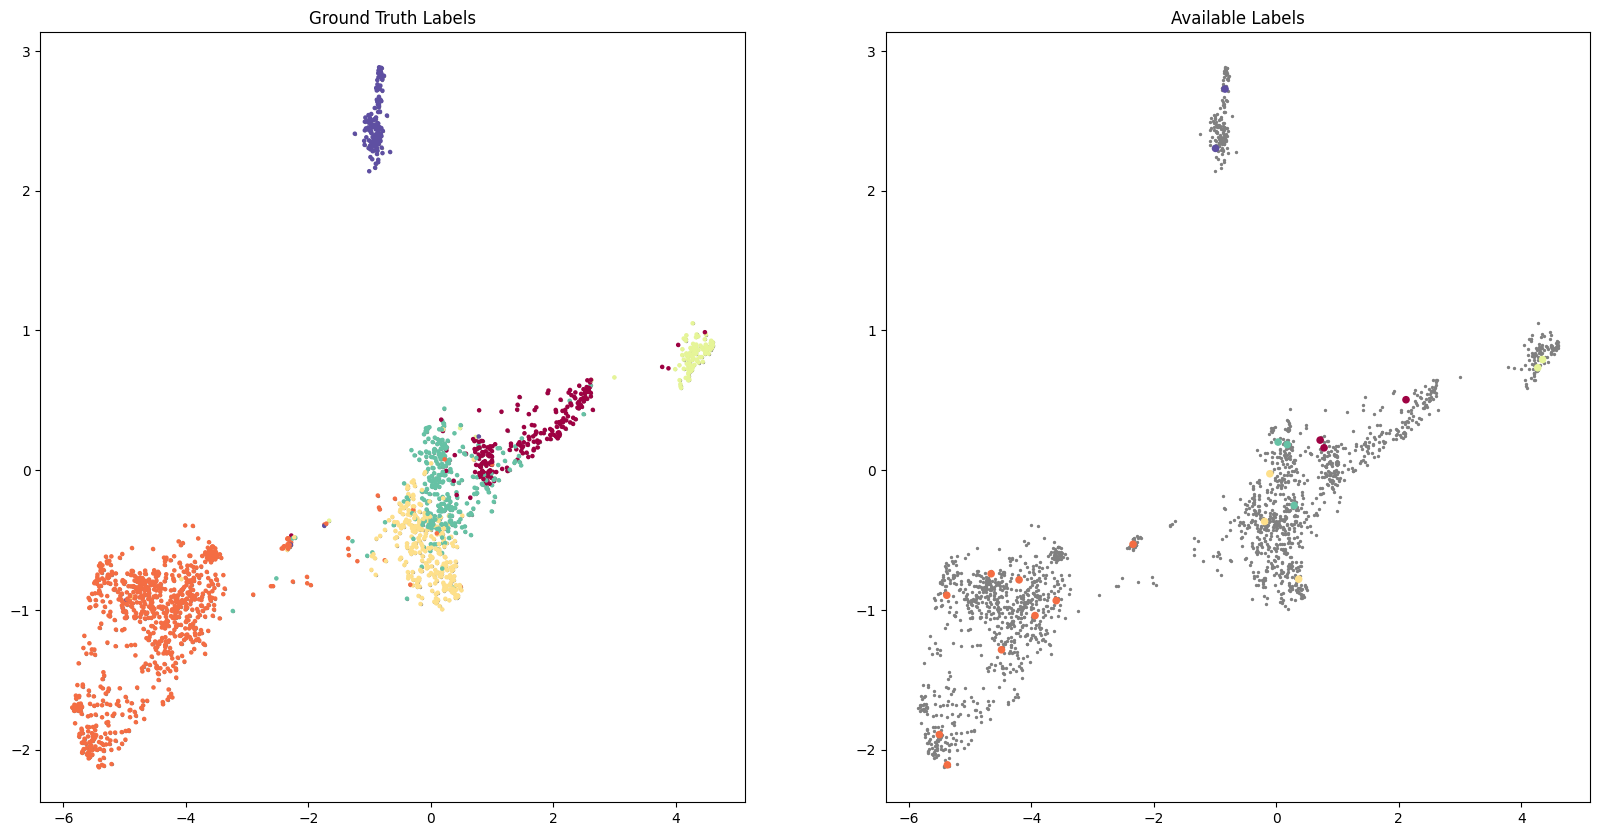

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.scatter(Embedding[:,0], Embedding[:,1], c = 'grey', s = 2)
ax1.scatter(Embedding[:,0], Embedding[:,1], c = true_labels, s = 5, cmap = 'Spectral')
ax1.set_title("Ground Truth Labels")
ax2.scatter(Embedding[:,0], Embedding[:,1], c = 'grey', s = 2)
ax2.scatter(Embedding[:,0], Embedding[:,1], c = targets, s = 20, cmap = 'Spectral')
ax2.set_title("Available Labels")
plt.show() 

In [6]:
print(Embedding)

[[ 2.322821    0.33200687  4.2914295   4.7651668   2.2081723 ]
 [ 0.7784231   0.17999092  5.4506235   4.560969    3.1497824 ]
 [ 0.171216    0.21404666  4.8678274   5.820158    3.1685848 ]
 ...
 [ 4.6031904   0.890498    4.7333226   5.1136937   2.881446  ]
 [-4.7152004  -1.7054185   2.5380704   6.0854073   1.3215421 ]
 [ 0.34833115 -0.5238359   3.4196358   6.3393703   2.0432434 ]]


1. We start by creating the architecture and the forward pass.
- As a reference this is what we are looking for:

In [7]:
# model.torch_module

- Notice that the classifier is just a feed forward fully connected network. And the regularization layers go from each of the inner layers to a low-dimensional representation in this case the dimension of $\mathcal{E}$ is 5. 
- The non-linearity is a ReLU activation altough you can try different things, but just apply it to the inner layers of the classifier. 

In [8]:
class MultiTaskModule(nn.Module):
    '''This module should be able to take any number of layers and dimensions. For instance, 
    if hidden_dims = [100, 100] the architecture should have two hidden layers with 100 neurons each. 
    If hidden_dims = [200, 100, 80] your code should generate 3 hidden layers.'''
    
    def __init__(self, input_dim, hidden_dims, z_dim, output_dim):
        super().__init__()

        self.layers = [nn.Linear(input_dim, hidden_dims[0])]
        
        for i in range(len(hidden_dims)-1):
            self.layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
        
        self.layers.append(nn.Linear(hidden_dims[-1], output_dim))
        self.classifier = nn.ModuleList(self.layers)
        
        
        self.R_layers = []
        for i in range(len(hidden_dims)):
            self.R_layers.append(nn.Linear(hidden_dims[i], z_dim))
            
        self.regularization = nn.ModuleList(self.R_layers)
        self.nl = nn.ReLU()
        # self.lact = nn.Softmax()
               
    def forward(self, x, noise = 0):
        
        C = []
        for i, l in enumerate(self.classifier):
            if i < 1:          
                x = l(x)
            elif  i == len(self.classifier)-1: 
                # x = self.lact(l(x))
                x = l(x)
            else:
                x = self.nl(l(x))
            C.append(x)
        
        R = []
        for i, l in enumerate(self.regularization):
            x = l(C[i])
            R.append(x)
        
        '''The output of the forward pass should be a list "R" that contains all the mappings from the inner layers to 
        the reference embeddings, and a classification activations'''
        return R, C[-1]
    



In [9]:
'''This class '''
class dataset_ss(Dataset):
        def __init__(self, X, y):
            self.X = X
            self.y = y
        def __len__(self):
            return len(self.X)   
        def __getitem__(self, idx):
            return self.X[idx], self.y[idx], idx

2. Now the model containing a fit method.

- Since we are going to have a very few labeled observations, we actually want to have them in every mini-batch. So the data coming out from the data loader in the 

In [44]:
def geo_reg(G, E):
    return torch.sum(torch.tensor([torch.pow(torch.norm(g - E), 2) for g in G]))

class GRNN():
    """Geometry regularized neural network"""
    def __init__(self, *, 
                 lr=1e-4, 
                 epochs=1000, 
                 batch_size=64, 
                 weight_decay=0,
                 hidden_dims=[100, 100, 100], 
                 lam = 0):
        
        # The learning rate for the optimizer 
        self.lr = lr
        
        # number of epochs and batch size
        self.epochs = epochs
        self.batch_size = batch_size
        self.weight_decay = weight_decay
        
        # dimension of the hidden layers
        self.hidden_dims = hidden_dims  
        
        # Regularization parameter to recover the reference embedding 
        self.lam = lam
        
        '''***define the classification criterion***'''
        self.criterion_reg = nn.MSELoss()
        self.criterion_cla = nn.CrossEntropyLoss()

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
    def fit(self, X, E, y):
        
        '''X is your features, E the reference embedding, y your targets.'''           
        self.y = torch.Tensor(y)
        self.X = torch.tensor(X).float() 

        
        self.shape = X.shape
        input_size = self.shape[1]
        self.E = torch.tensor(E).float()
        
        # extracting the data with labels 
        idx2 = torch.where(~torch.isnan(self.y))[0]
        self.E_labels = self.E[idx2,:]
        self.data_labels = self.X[idx2,:]
        self.y_labels = self.y[idx2].long()
        self.n_classes = len(torch.unique(self.y_labels))
        
        
        # create the torch module        
        self.torch_module = MultiTaskModule(input_dim=input_size, output_dim = self.n_classes,
                                                  hidden_dims=self.hidden_dims,
                                                  z_dim=E.shape[1])
        self.torch_module.to(self.device)
        self.torch_module.train()

            
        # define the optimizer
        self.optimizer = torch.optim.Adam(self.torch_module.parameters(),
                                          lr=self.lr,
                                          weight_decay=self.weight_decay)
        
        
        
        data_set = dataset_ss(self.X, self.y)    
        self.loader = self.get_loader(data_set)
        
        
        for epoch in range(self.epochs):
            for batch in self.loader:
                self.optimizer.zero_grad()
                self.train(batch)
                self.optimizer.step()
            if epoch % 100 == 0:
                print(f"Epoch {epoch} out of {self.epochs} ==== Loss: {self.loss.item()}") 


    def get_loader(self, X):
        return torch.utils.data.DataLoader(X, batch_size=self.batch_size, shuffle=False)

    def train(self, batch):
        
        x, y, idx = batch
        '''*** Complete the computation of the loss and as the last step of this train function call loss.backward() 
        remember you will need self.criterion_reg and self.criterion_cla
        ***
        '''
        
        x = torch.cat((x, self.data_labels))
        y = torch.cat((y, self.y_labels))
        E = torch.cat((self.E[idx], self.E_labels))
        idx2 = torch.where(~torch.isnan(y))[0]
        
        x = x.to(self.device) 
        y = y.to(self.device)
        E = E.to(self.device)
        reg_N, y_hat = self.torch_module(x)

        self.loss = self.criterion_cla(y_hat[idx2], y[idx2].long()) 
        self.loss_manf = self.lam * self.criterion_reg(torch.stack(reg_N), E)
        self.loss += self.loss_manf
        self.loss.backward()
        
    
    def predict(self, X):
        reg_N, y_hat = self.torch_module(torch.tensor(X).float().to(self.device))
        y_hat = y_hat.argmax(1).detach().cpu().numpy()
        reg_N = [i.detach().cpu().numpy() for i in reg_N]
        return reg_N, y_hat
        

    

In [45]:
# Let's have a quick test with and without regularization
# lam = 0 means the geometry regularization plays no role and we have the vanilla NN

model = GRNN(epochs = 500, lam = 0)
model.fit(X, Embedding, targets)
En, y_hat = model.predict(X)

C:\Users\seanr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([86, 5])) that is different to the input size (torch.Size([3, 86, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\seanr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([85, 5])) that is different to the input size (torch.Size([3, 85, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0 out of 500 ==== Loss: 1.6662254333496094 0.0
Epoch 100 out of 500 ==== Loss: 0.00011643322795862332 0.0
Epoch 200 out of 500 ==== Loss: 1.3055902854830492e-05 0.0
Epoch 300 out of 500 ==== Loss: 2.125032324329368e-06 0.0
Epoch 400 out of 500 ==== Loss: 3.524448288771964e-07 0.0


In [42]:
# lam = 1 imposes the regularization

model = GRNN(epochs = 500, lam = 1,  hidden_dims = [100, 80, 30])
model.fit(X, Embedding, targets)
En_r, y_hat_r = model.predict(X)

Epoch 0 out of 500 ==== Loss: 14.244184494018555 
Epoch 100 out of 500 ==== Loss: 0.3376685380935669 
Epoch 200 out of 500 ==== Loss: 0.22646357119083405 
Epoch 300 out of 500 ==== Loss: 0.17692895233631134 
Epoch 400 out of 500 ==== Loss: 0.15288101136684418 


0.5646422506727621
0.8753927692731676


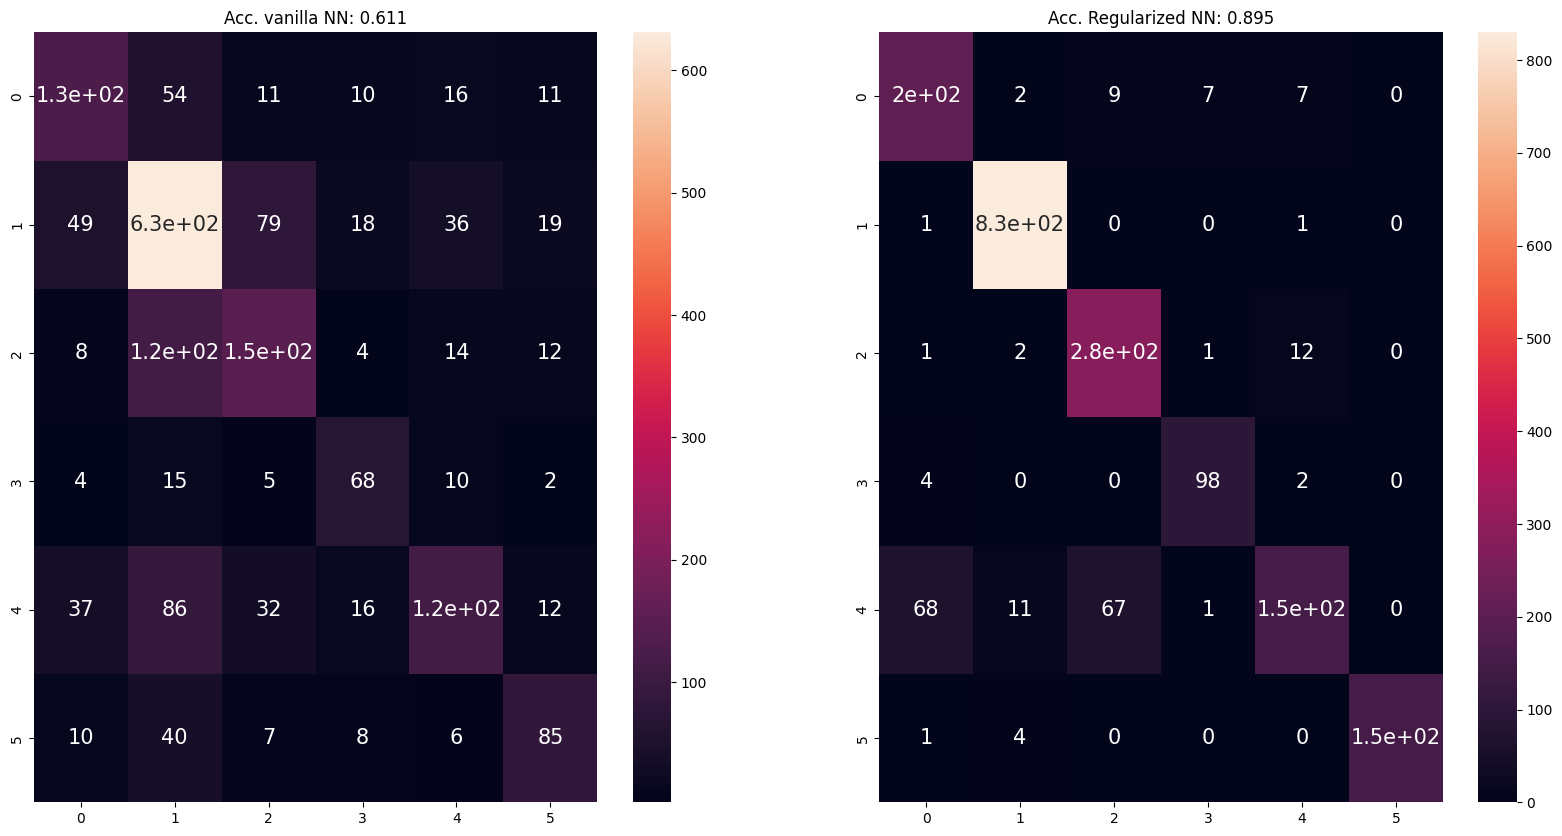

In [43]:
acc = sklearn.metrics.accuracy_score(true_labels, y_hat)
print(sklearn.metrics.balanced_accuracy_score(true_labels, y_hat))
cm = sklearn.metrics.confusion_matrix(true_labels, y_hat)
df_cm = pd.DataFrame(cm, range(6), range(6))

acc_r = sklearn.metrics.accuracy_score(true_labels, y_hat_r)
print(sklearn.metrics.balanced_accuracy_score(true_labels, y_hat_r))
cm = sklearn.metrics.confusion_matrix(true_labels, y_hat_r)
df_cm_r = pd.DataFrame(cm, range(6), range(6))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
sns.heatmap(df_cm, annot=True, annot_kws={"size": 15}, ax = ax1) 
ax1.set_title(f"Acc. vanilla NN: {acc:.3f}")
sns.heatmap(df_cm_r, annot=True, annot_kws={"size": 15}, ax = ax2) 
ax2.set_title(f"Acc. Regularized NN: {acc_r:.3f}")
plt.show()

In [ ]:
# SEEDS = [111]
# plabels = np.array([0.01, 0.05])
# lambdas = [0, 1]
# RUNS = 10


# pandas data frame to store the results
# columns_names = ["Model", "Dataset", "Test acc", "Labeled percentage", "Number of Layers", "RUN"]
# inds = []
# df = pd.DataFrame(data=None, index=inds, columns=columns_names, 
#                   dtype=None, copy=False)
#     for per_labels in plabels:
#         for run in range(RUNS):
#             X, true_labels, targets, test_ind = get_pbmc(perc_labels = 0.02)
#             Embedding = umap.UMAP(n_neighbors=20, n_components = 5, min_dist=0.01).fit_transform(X)
#             for lamb in lambdas:
                